In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

import os
from datetime import datetime
from pathlib import Path
import sys
import xlrd
import pycountry
from statistics import mean
import datetime as dt
import statsmodels.api as sm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('review_is.csv')
df2 = df[['date', 'rating', 'number_of_reviews', 'number_of_friends',
          'Negative_SentiStrength_Score', 'Positive_SentiStrength_Score', 'Average_SentiStrength_Score', ]]

df2 = df2.rename(columns={'Negative_SentiStrength_Score': 'negative_sentiment', 'Positive_SentiStrength_Score': 'positive_sentiment',
                          'Average_SentiStrength_Score': 'average_sentiment', })
df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
df2['date'] = df2['date'].map(dt.datetime.toordinal) - 733606

df2.head(3)

,date,rating,number_of_reviews,number_of_friends,negative_sentiment,positive_sentiment,average_sentiment
0,4254,5,74,126,-1,4,3
1,4129,5,466,196,-3,4,1
2,4223,5,274,183,-1,4,3


In [3]:
from sklearn.model_selection import train_test_split

X = df2.drop(columns=['number_of_friends'])
y = df2['number_of_friends']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [4]:
mdl = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor]

for i in mdl:
    model = i()
    name = type(model).__name__
    model.fit(X_train, y_train)
    
    train_score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1).mean().round(4)
    test_score = model.score(X_test, y_test).round(4)
    
    print(f'<{name}>')
    print(f'training score: {train_score}')
    print(f'testing  score: {test_score}')
    print('')

<LinearRegression>
training score: 0.2252
testing  score: 0.2779

<DecisionTreeRegressor>
training score: 0.0847
testing  score: 0.177

<RandomForestRegressor>
training score: 0.4974
testing  score: 0.5724

<GradientBoostingRegressor>
training score: 0.491
testing  score: 0.6195



In [5]:
model= GradientBoostingRegressor()
model.fit(X_train, y_train)
    
train_score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1).mean().round(4)
test_score = model.score(X_test, y_test).round(4)
    
print(f'training score: {train_score}')
print(f'testing  score: {test_score}')

training score: 0.4941
testing  score: 0.6193


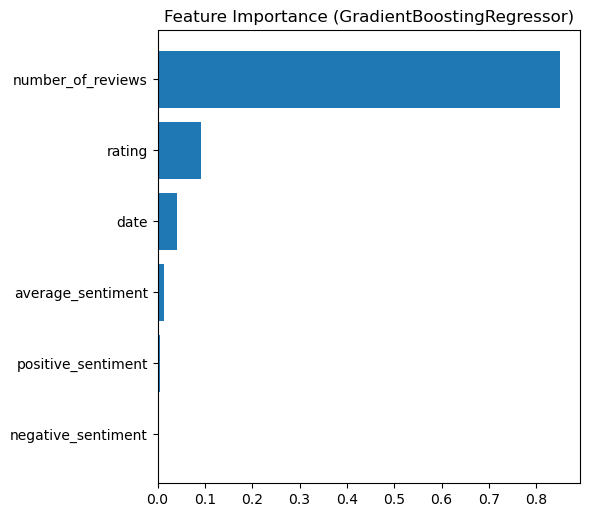

In [6]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (GradientBoostingRegressor)')
plt.show()

bad_col_gbr = X_train.columns[sorted_idx]

In [7]:
col = bad_col_gbr    
train_score_gbr = []
test_score_gbr = []

for i in range(len(col)):
    X_train2 = X_train.drop(columns=col[:i])
    X_test2 = X_test.drop(columns=col[:i])

    # Modeling
    model = GradientBoostingRegressor()
    model.fit(X_train2, y_train)
    a = cross_val_score(model, X_train2, y_train, cv=5, n_jobs=-1).mean().round(4)
    b = model.score(X_test2, y_test).round(4)

    train_score_gbr.append(a)
    test_score_gbr.append(b)

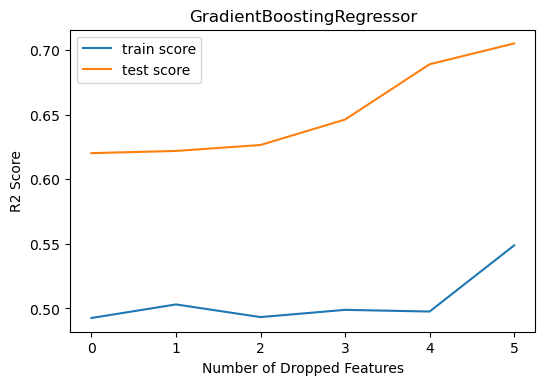

,dropped_feature,train_score,test_score
1,NaN,0.4926,0.6202
2,negative_sentiment,0.5031,0.6219
3,positive_sentiment,0.4933,0.6265
4,average_sentiment,0.4989,0.6462
5,date,0.4976,0.6890
6,rating,0.5488,0.7051


In [8]:
col = ['NaN', 'negative_sentiment', 'positive_sentiment', 'average_sentiment', 'date', 'rating']

df_gbr = pd.DataFrame(data={'dropped_feature': col, 'train_score': train_score_gbr, 'test_score': test_score_gbr},
                      index=np.arange(1,7))
xlabel = np.arange(0,len(df_gbr))

plt.plot(xlabel, df_gbr['train_score'], label='train score')
plt.plot(xlabel, df_gbr['test_score'], label='test score')

plt.xticks(np.arange(0, len(df_gbr), 1))
plt.xlabel('Number of Dropped Features')
plt.ylabel('R2 Score')
plt.title('GradientBoostingRegressor')
plt.legend()
plt.show()

df_gbr

In [9]:
y_test

1615     10
7930      3
8456      0
8100      0
6744    141
       ... 
2984      0
8911      8
2036     58
7250    480
6567      4
Name: number_of_friends, Length: 1824, dtype: int64

In [10]:
test = pd.concat([X_test, y_test], axis=1)
test = test.sort_values(by='number_of_friends')
X_test3 = test.drop(columns='number_of_friends')
y_test3 = test['number_of_friends']

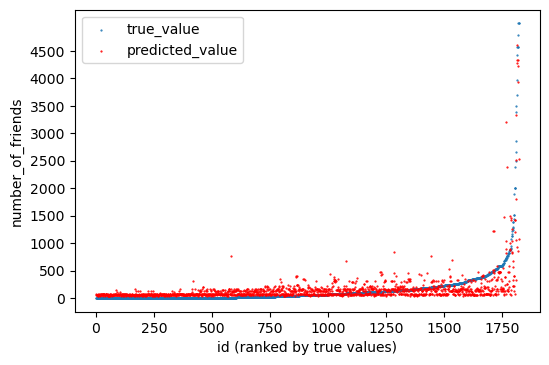

In [11]:
model= GradientBoostingRegressor()
model.fit(X_train, y_train)

x = model.predict(X_test3)
y = y_test3
z = list(range(0, len(x)))

plt.scatter(z, y, s=0.3, label='true_value')
plt.scatter(z, x, s=0.3, c='r', label='predicted_value')
plt.xlabel('id (ranked by true values)')
plt.ylabel('number_of_friends')
plt.yticks(np.arange(0, 5000, step=500))
plt.legend()
plt.show()

In [12]:
y_test3.iloc[1000]

64